In [1]:
import os, glob
import sys
import json
from PIL import Image
from collections import Counter

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import tifffile as tiff
import matplotlib.pyplot as plt
from tqdm import tqdm

import cv2

from sklearn.model_selection import KFold

sys.path.append("detection-wheel")

In [2]:
sys.path.append("sumo")
import normalisation

In [3]:
EPOCHS = 150

# Example of using "normalizeStaining" function

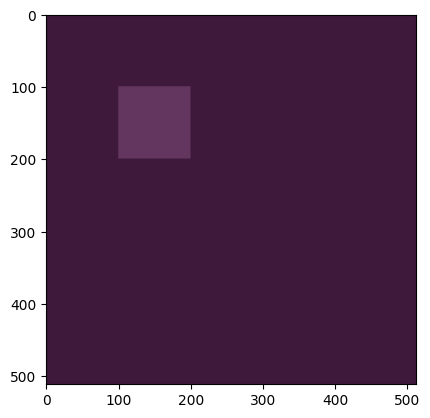

In [4]:
img = np.zeros((512, 512, 3), dtype=np.uint8)
img[100:200, 100:200, 0] = 255

new_img = normalisation.normalizeStaining(img)[0]

plt.imshow(new_img)

In [5]:
def preprocess_fn_train(img):
    # convert img to uint8
    img = img.permute(1,2,0).cpu().numpy()
    img = (img * 255).astype(np.uint8)
    
    
    Io=np.random.uniform(200, 300)
    # random number between 1 and 5
    alpha = np.random.uniform(1, 3)
    beta=np.random.uniform(0.15, 0.25)
    
    
    new_img = normalisation.normalizeStaining(img, Io=Io, alpha=alpha, beta=beta)[0]
    img = torch.from_numpy(new_img).float() / 255.0
    img = img.permute(2,0,1)
    
    return img


def preprocess_fn_val(img):
    # convert img to uint8
    img = img.permute(1,2,0).cpu().numpy()
    img = (img * 255).astype(np.uint8)
    new_img = normalisation.normalizeStaining(img)[0]
    img = torch.from_numpy(new_img).float() / 255.0
    img = img.permute(2,0,1)
    
    return img

# Dataset

In [6]:
import os
import numpy as np
import torch
from PIL import Image
from torchvision.transforms import functional as F, InterpolationMode

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, imgs, masks, transforms, mode):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = imgs#sorted(glob.glob('/kaggle/input/hubmap-making-dataset/train/image/*.png'))
        self.masks = masks#sorted(glob.glob('/kaggle/input/hubmap-making-dataset/train/mask/*.png'))
        
        self.mode = mode

    def __getitem__(self, idx):
        # load images and masks
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]
        img = Image.open(img_path).convert("RGB")
        
        
        
        
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path).convert('L')
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        #masks = (mask == obj_ids[:, None, None])
        #print((obj_ids[:, None, None]).shape)
        #masks = mask == obj_ids[:, None, None]
        masks = [np.where(mask== obj_ids[i, None, None],1,0) for i in range(len(obj_ids))]
        masks = np.array(masks)

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.nonzero(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        try:
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            #print(area,area.shape,area.dtype)
        except:
            area = torch.tensor([[0],[0]])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        #print(masks.shape)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)


        if np.random.uniform() > 0.5:
            img = preprocess_fn_train(img)
            
        if self.mode == 'train':
            rand_width_height = 1024+512 # np.random.randint(512, 1024)
            # resize to 1024x1024
            new_width = rand_width_height
            new_height = rand_width_height
            orig_height, orig_width = img.shape[1:]
            # orig_height = img.size[1]
            # orig_width = img.size[0]
            
            img = F.resize(img, [new_height, new_width], interpolation=InterpolationMode.BILINEAR)

            if target is not None:
                target["boxes"][:, 0::2] *= new_width / orig_width
                target["boxes"][:, 1::2] *= new_height / orig_height
                if "masks" in target:
                    target["masks"] = F.resize(
                        target["masks"], [new_height, new_width], interpolation=InterpolationMode.NEAREST
                    )
            
        

        return img, target

    def __len__(self):
        return len(self.imgs)

In [7]:
import torchvision
from torchvision.models import list_models
detection_models = list_models(module=torchvision.models.detection)
detection_models

['fasterrcnn_mobilenet_v3_large_320_fpn',
 'fasterrcnn_mobilenet_v3_large_fpn',
 'fasterrcnn_resnet50_fpn',
 'fasterrcnn_resnet50_fpn_v2',
 'fcos_resnet50_fpn',
 'keypointrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn',
 'maskrcnn_resnet50_fpn_v2',
 'retinanet_resnet50_fpn',
 'retinanet_resnet50_fpn_v2',
 'ssd300_vgg16',
 'ssdlite320_mobilenet_v3_large']

In [8]:
import torchvision
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.resnet import ResNet50_Weights

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights="DEFAULT", weights_backbone=ResNet50_Weights.IMAGENET1K_V2)
    
    # Modify the Resize operation to resize to min 512 and max 768
    model.transform.min_size = (1536,)
    model.transform.max_size = 1536 # +(768-512)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [9]:
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
        transforms.append(T.RandomIoUCrop())
        transforms.append(T.RandomZoomOut())
        transforms.append(T.RandomPhotometricDistort())
        transforms.append(T.ScaleJitter())
        transforms.append(T.RandomShortestSize())
    return T.Compose(transforms)

In [10]:
from engine import train_one_epoch, evaluate
import utils

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [12]:
n_imgs = len(glob.glob('/home/viktor/Documents/kaggle/hubmap-2023/experiments/mask-rcnn/new-dataset/train/image/*'))
n_imgs

1622

In [13]:
kf = KFold(n_splits=5, shuffle=True, random_state=43)
for i, (train_index, test_index) in enumerate(kf.split(range(n_imgs))):
    if i==0:
        break
all_imgs = sorted(glob.glob('/home/viktor/Documents/kaggle/hubmap-2023/experiments/mask-rcnn/new-dataset/train/image/*.png'))
all_masks = sorted(glob.glob('/home/viktor/Documents/kaggle/hubmap-2023/experiments/mask-rcnn/new-dataset/train/mask/*.png'))
all_imgs = np.array(all_imgs)
all_masks = np.array(all_masks)
train_img = all_imgs[train_index]
train_mask = all_masks[train_index]
val_img = all_imgs[test_index]
val_mask = all_masks[test_index]
dataset_train = PennFudanDataset(train_img, train_mask, get_transform(train=True), mode='train')
dataset_val = PennFudanDataset(val_img, val_mask, get_transform(train=False), mode='val')
train_dl = torch.utils.data.DataLoader(
    dataset_train, batch_size=2, shuffle=True, num_workers=4, pin_memory=True, drop_last=True, collate_fn=utils.collate_fn)
val_dl = torch.utils.data.DataLoader(
    dataset_val, batch_size=1, shuffle=False, num_workers=os.cpu_count(), pin_memory=True,collate_fn=utils.collate_fn)



/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


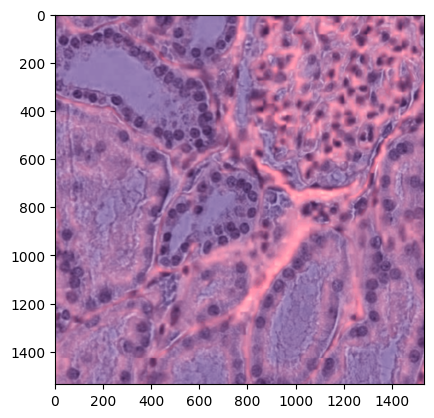

In [14]:
img = dataset_train[0][0].detach().cpu().numpy().transpose(1, 2, 0)
# convert to uint8
img = (img * 255).astype(np.uint8)

plt.imshow(img)

In [15]:
# new_img = normalisation.normalizeStaining(img, Io=240)[0]

# plt.imshow(new_img)

In [16]:
import sys

# Create a custom function to log output
def log_output(text):
    with open('output.log', 'a') as f:
        f.write(text)

# Redirect stdout to the custom log function
sys.stdout.write = log_output


In [17]:
model = get_model_instance_segmentation(num_classes=2)
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0003, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.985)

for epoch in range(EPOCHS):
    train_one_epoch(model, optimizer, train_dl, device, epoch, print_freq=50)
    evaluate(model, val_dl, device=device, preprocess_fn=preprocess_fn_val)
    scheduler.step()
    model_path = f'ckpts/fold_{i}_epoch{epoch}.pth'
    torch.save(model.state_dict(), model_path)
    

Epoch: [0]  [  0/324]  eta: 0:19:24  lr: 0.000300  loss: 5.0249 (5.0249)  loss_classifier: 0.6945 (0.6945)  loss_box_reg: 0.2002 (0.2002)  loss_mask: 2.0686 (2.0686)  loss_objectness: 1.9536 (1.9536)  loss_rpn_box_reg: 0.1079 (0.1079)  time: 3.5934  data: 1.7576  max mem: 15592
Epoch: [0]  [ 50/324]  eta: 0:02:31  lr: 0.000300  loss: 1.2468 (1.5054)  loss_classifier: 0.2127 (0.2502)  loss_box_reg: 0.2040 (0.1967)  loss_mask: 0.5192 (0.7832)  loss_objectness: 0.1159 (0.1959)  loss_rpn_box_reg: 0.0651 (0.0794)  time: 0.4959  data: 0.0002  max mem: 16251


KeyboardInterrupt: 